<a href="https://colab.research.google.com/github/raunakkaul/personalprojects/blob/main/Movie_data_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Predictive model using machine learning algorithms to forecast the success of movies based on various variables. Feature engineering techniques were implemented to optimize datasets, improving the overall performance of the model. The development process involved leveraging scikit-learn and sentiment analysis for efficient analysis of movie reviews, contributing to a comprehensive approach in building and assessing the model.


* Title: The movie's title
* Genre: The movie's genre
* Stars: The number of famous actors in the movie
* Runtime: The length of the movie's runtime
* Budget: How much was spent on filming the movie (in millions)
* Promo: How much money was spent promoting the movie (in millions)
* Season: The season in which the movie was released
* Rating: The movie's rating
* R1: Reviewer 1's review
* R1: Reviewer 2's review
* R1: Reviewer 3's review

And the target variable:

* Success: Whether the film was a success or a flop

# Data loading

Load the data

In [ ]:
!pip install vaderSentiment

In [ ]:

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier


df = pd.read_csv("Data.csv")

In [ ]:
#Drop meaningless column
df = df.drop('Unnamed: 0', axis=1)

# Data Cleaning

*Runtime for some movies is 0 which is not possible. I will fix this by doing mean imputation. Runtime across all movies is mostly similar, so this should not affect data.

*Stars for some movies is 100 which is not possible, especially given the low movie budget. I will omit these values as there is not a way to estimate their number of stars without assigning mostly arbitray values. While mode imputaiton is possible, the difference of even 1 star extra or 1 star less might have a big  impact on the target variable so I would rather not take the risk. Additionally, there are very few entries like this so that dataset will not be heavily affected.

*The budget for some movies is incredibly high. This is most likely a typo and they are likely not entered in the correct units. Each of these typos seem to be entered as a raw value rather than in millions(which is the unit for the rest of the data). I will fix this by converting the value into millions.

In [ ]:
#Runtime fix
df['Runtime'].replace(0, np.nan, inplace=True)

mean = df['Runtime'].mean()

df['Runtime'].fillna(mean, inplace=True)

In [ ]:
#Stars fix
df = df[df['Stars'] != 100]

In [ ]:
#Budget fix
df['Budget'] = df['Budget'].apply(lambda x: x / 1000000.0 if x > 1000000.0 else x)

# Data Exploration





Does Season have a stastically significant impact on a movie's success?

**p-value:** 0.006534648782285328

In [ ]:
#Contingency table
cont = pd.crosstab(df['Season'], df['Success'])
print(cont)

#Getting p-value
chi, p, a, b = chi2_contingency(cont)

print("P-value  is:", p)

Success  False  True 
Season               
Fall        89     23
Spring      87     10
Summer     149     58
Winter      95     27
P-value  is: 0.006534648782285328


Here, due to a low p-value of less than 0.05, we can reject the null hypothesis and conclude that season does have a statistically significant impact on a movie's success.

Do seasons have a statistically significant difference in their distribution of content ratings?

**p-value:** 0.2096305929818337

In [ ]:
#Making contingency table
cont = pd.crosstab(df['Season'], df['Rating'])
print(cont)

#Getting p-value
chi2, p, a, b = chi2_contingency(cont)
print("P-value  is:", p)

Rating  PG  PG13   R
Season              
Fall    42    38  32
Spring  33    35  29
Summer  64    71  72
Winter  55    39  28
P-value  is: 0.2096305929818337


The p-value is quite high, so it is likely that we can accecpt the null hypothesis and assume that season and content rating are independent of each other and there is no statistically ignificant difference in their distribution.

Who is the harshest critic (highest precent of negative reviews)?

**Critic:**R1

In [ ]:
#Get a sentiment score using the exsting library
df['sent1'] = df['R1'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
df['sent2'] = df['R2'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])
df['sent3'] = df['R3'].apply(lambda x: SentimentIntensityAnalyzer().polarity_scores(x)['compound'])

In [ ]:
df['neg1'] = df['sent1'] < 0.5
df['neg2'] = df['sent2'] < 0.5
df['neg3'] = df['sent3'] < 0.5

#Calculating which has the largest portion of reviews below a certain threshold of negative sentiment
worst = max(('R1', df['neg1'].mean()),('R2', df['neg2'].mean()), ('R3', df['neg3'].mean()),key=lambda x: x[1])

print(worst[0])



R1


In [ ]:
#Dropping these columns as they are no longer needed
df = df.drop('sent1', axis = 1)
df = df.drop('sent2', axis = 1)
df = df.drop('sent3', axis = 1)
df = df.drop('neg1', axis = 1)
df = df.drop('neg2', axis = 1)
df = df.drop('neg3', axis = 1)


In [ ]:
cov = df['Promo'].cov(df['Budget'])
print(cov)

1908.7277141886009


This is a high covariance considering it is positive and that it is quite large compared to the magnitude of the values in promo and budget.

# Data Visualization

Chart that compares the distribution of the budget for each different number of stars.

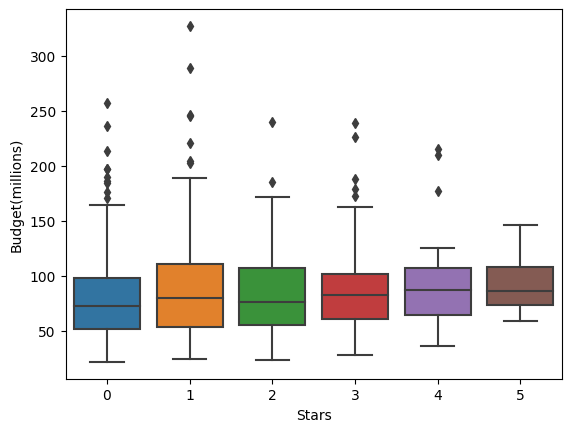

In [ ]:
sns.boxplot(x='Stars', y='Budget', data=df)
plt.xlabel('Stars')
plt.ylabel('Budget(millions)')
plt.show()

Graph showing the average movie budget over time.

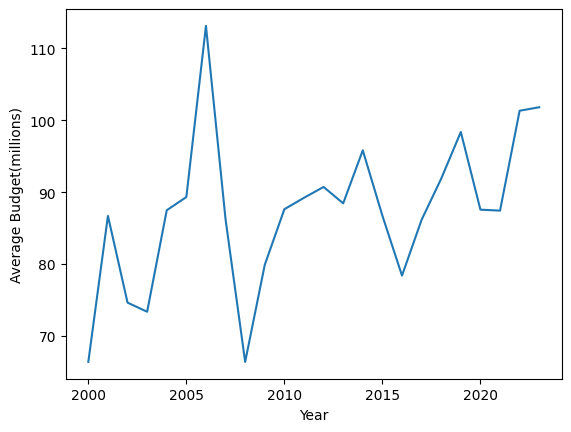

In [ ]:
avg = df.groupby('Year')['Budget'].mean()
plt.plot(avg.index, avg.values)
plt.xlabel('Year')
plt.ylabel('Average Budget(millions)')
plt.show()


# Feature Engineerin


*I will use the vaderSentiment library to say whether a review is positive or negative. This will replace the existing reviews for each reviewer with a number score to measure their sentiment.

*I will use PCA and negate title since it is mostly irrelevant. It is possible that sequel movies or remakes may automatically recieve better ratings or make more money. This is someting that is hard to measure and I decided that for most movies, the title will not be as relevant as the other features. It is also possible that title may sound particularly exciting for some of the audience, but this is also something I thought would be convluted and was not too sure would be easy to measure.

*I will one-hot encode Season, Rating and Genre to turn them into numeric values.

In [ ]:
#Title feature engineering
df = df.drop('Title', axis=1)

In [ ]:
#One hot coding feature engineering
df = pd.get_dummies(df, columns=['Rating'], prefix='Rating')
df = pd.get_dummies(df, columns=['Season'], prefix='Season')
df = pd.get_dummies(df, columns=['Genre'], prefix='Genre')


In [ ]:
#Replacing reviews with a numeric value measuring their sentiment

#Method that will measure the sentiment
def replace(col):
    sentiment = SentimentIntensityAnalyzer()
    scores = col.apply(lambda x: sentiment.polarity_scores(x)['compound']) + 0.5
    return scores

df['R1'] = replace(df['R1'])
df['R2'] = replace(df['R2'])
df['R3'] = replace(df['R3'])

# Modeling

I chose a random forest model

In [ ]:
X = df.drop('Success', axis=1)
y = df['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)


RandomForestClassifier()

# Testing

#Accuracy test with 90-10 split


**Model accuracy:**0.8333333333333334



In [ ]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.8333333333333334


#Confusion matrix


**False negative rate:** 16

**False positive rate:** 0

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[41  0]
 [ 9  4]]




**Most important feature:** R1


In [ ]:
clf = RandomForestClassifier()
clf.fit(X, y)
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': clf.feature_importances_})
print(feature_importances)


                  Feature  Importance
0                 Runtime    0.087478
1                   Stars    0.086424
2                    Year    0.064961
3                  Budget    0.101259
4                   Promo    0.121628
5                      R1    0.260373
6                      R2    0.073415
7                      R3    0.066879
8               Rating_PG    0.012846
9             Rating_PG13    0.013737
10               Rating_R    0.015385
11            Season_Fall    0.009688
12          Season_Spring    0.010703
13          Season_Summer    0.011984
14          Season_Winter    0.011504
15           Genre_Action    0.021473
16            Genre_Drama    0.011140
17          Genre_Fantasy    0.004747
18  Genre_Romantic Comedy    0.010583
19  Genre_Science fiction    0.003790


As can be seen from the list above, R1 is the most important feature
